In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import copy

from networkx.algorithms import community

warnings.simplefilter('ignore')

In [2]:
def readNet(filename):
    net = {}

    with open(filename, "r") as file:
        n = int(file.readline())
        net['noNoes'] = n

        mat = []
        degrees = []
        noEdges = 0
        for i in range(n):
            mat.append([])
            line = file.readline()
            elems = line.split(" ")

            degree = 0
            for j in range(n):    
                el = int(elems[j])
                if el == 1:
                    degree += 1
                if j > i:
                    noEdges += el 
                    
                mat[-1].append(el)
            
            degrees.append(degree)

    net["mat"] = mat
    net["noEdges"] = noEdges
    net["degrees"] = degrees

    return net

In [3]:
# identify the communities (by a tool) and plot them

def greedyCommunitiesDetectionByTool(network):
    # Input: a graph
    # Output: list of comunity index (for every node)

    from networkx.algorithms import community

    G = network
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    sorted(map(sorted, top_level_communities))
    communities = [0 for node in range(G.number_of_nodes())]
    index = 1
    minim = 1000
    for community in sorted(map(sorted, top_level_communities)):
        minim = min(minim, min(community))
    for community in sorted(map(sorted, top_level_communities)):
        for node in community:
            communities[node - minim] = index
        index += 1
    return communities

In [4]:
"""
    Metoda care citeste un graf dintr-un fisier de tip gml
    @params: filename - path catre un fisier gml
    @return: Graph - un obiect de tip Graph
"""
def readGraph(filename):
    graph = nx.read_gml(os.path.join(os.getcwd(), 'data', 'dolphins', 'dolphins.gml'))

    return graph

In [5]:
def readCommunityClasses(filename):
    classes = []

    with open(filename, "r") as file:
        for line in file:
            classes.append(int(line.split(" ")[-1]))
    
    return classes

In [6]:
"""
def plotNetwork(network, communities = [[1, 1, 1, 1, 1, 1]]):
    np.random.seed(42)

    A = np.matrix(network["mat"])
    G = nx.from_numpy_matrix(A) # returneaza un graf pe baza unei matrici (de adiacenta)
    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)
    
    plt.figure(figsize = (4, 4))
    nx.draw_networkx_nodes(G, pos, node_size = 600, cmap = plt.cm.RdYlBu, node_color = communities)
    nx.draw_networkx_edges(G, pos, alpha = 0.3) # alpha = edge transparancy
    plt.show(G)
"""

'\ndef plotNetwork(network, communities = [[1, 1, 1, 1, 1, 1]]):\n    np.random.seed(42)\n\n    A = np.matrix(network["mat"])\n    G = nx.from_numpy_matrix(A) # returneaza un graf pe baza unei matrici (de adiacenta)\n    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)\n    \n    plt.figure(figsize = (4, 4))\n    nx.draw_networkx_nodes(G, pos, node_size = 600, cmap = plt.cm.RdYlBu, node_color = communities)\n    nx.draw_networkx_edges(G, pos, alpha = 0.3) # alpha = edge transparancy\n    plt.show(G)\n'

In [7]:
def plotNetwork(G, communities = [[1, 1, 1, 1, 1, 1]], node_size = 50):
    np.random.seed(42)

    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)
    
    plt.figure(figsize = (5, 5))
    nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = communities)
    nx.draw_networkx_edges(G, pos, alpha = 0.3) # alpha = edge transparancy
    nx.draw_networkx_labels(G, pos) # alpha = edge transparancy
    plt.show(G)

In [8]:
"""
    Metoda care afiseaza impartirea in comunitati a algoritmului impreuna cu cea true, daca aceasta este data
    @params: G - reteaua
             predictedCommunities - impartirea in comunitati prezisa
             targetCommunities - adevarata impartirea in comunitati
             node_size - marimea nodurilor din desen 
"""
def plotPredictedTargetNetwork(G, modularity, predictedCommunities, targetCommunities = None, node_size = 50):
    np.random.seed(42)

    pos = nx.spring_layout(G) # returneaza un dictionar de forma (nod, pozitie)

    fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

    nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = predictedCommunities, ax = axis[0])
    nx.draw_networkx_edges(G, pos, alpha = 0.3, ax = axis[0]) # alpha = edge transparancy
    nx.draw_networkx_labels(G, pos, ax = axis[0]) # alpha = edge transparancy
    axis[0].set_title("Predicted \n number of communities = " + str(len(np.unique(predictedCommunities))) + "\n modularity = " + str(modularity))

    if targetCommunities != None:
        nx.draw_networkx_nodes(G, pos, node_size = node_size, cmap = plt.cm.RdYlBu, node_color = targetCommunities, ax = axis[1])
        nx.draw_networkx_edges(G, pos, alpha = 0.3, ax = axis[1]) # alpha = edge transparancy
        nx.draw_networkx_labels(G, pos, ax = axis[1]) # alpha = edge transparancy
        axis[1].set_title("target")

In [9]:
"""
crtDir = os.getcwd()
filePath = os.path.join(crtDir, 'data', 'net.in')
network = readNet(filePath)

plotNetwork(network)
"""

"\ncrtDir = os.getcwd()\nfilePath = os.path.join(crtDir, 'data', 'net.in')\nnetwork = readNet(filePath)\n\nplotNetwork(network)\n"

In [10]:
class DetectingCommunities:
    
    """
        Date de intrare: graful aferent sau fisierul gml in care se afla graful
        Date de iesire: un vector care precizeaza pentru fiecare nod in ce comunitate se afla
    """
    def __init__(self, graph, numberOfCommunities = 1):
        if graph == None:
            raise Exception("None attributes")

        self.__graph = graph
        
        self.__communities = dict([(i, [i]) for i in self.__graph.nodes])
        self.__forest = dict(zip(self.__graph.nodes, self.__graph.nodes))
        self.__result = self.__communities
        self.__numberOfCommunities = numberOfCommunities

        self.__e = dict()
        for node in self.__graph.nodes:
            self.__e[node] = dict()
            self.__e[node][node] = 0
            for ngh in [x for x in self.__graph.neighbors(node) if x >= node]:
                if self.__graph.get_edge_data(node, ngh).get('weight') == None:
                    self.__e[node][ngh] = self.__graph.number_of_edges(node, ngh) / self.__graph.number_of_edges()
                else:
                    self.__e[node][ngh] = self.__graph[node][ngh].get('weight') / self.__graph.size(weight='weight')

        suma = sum([sum([x for _, x in self.__e[node].items()]) for node in self.__e])

        #self.__a = dict(zip(self.__graph.nodes, [sum([x for _, x in self.__e[i].items()]) for i in self.__e.keys()])) 
        self.__updateA()
        self.__updateQ()

        assert(len(self.__e) == len(self.__a))

        self.__maxq = self.__q

    """
        Metoda care da update la lista a
        @params: -
        @return: -
    """
    def __updateA(self):
        #self.__a = dict(zip(list(self.__communities.keys()), [sum([x for _, x in self.__e[i].items()]) for i in self.__communities.keys()])) 
        self.__a = dict()
        for community in self.__communities.keys():
            self.__a[community] = sum([self.__e[node].get(community, 0) for node in self.__e if node != community]) + sum([x for _, x in self.__e[community].items()])
    
    """
        Metoda care calculeaza modularitatea
        @params: -
        @return: modularitatea
    """
    def __updateQ(self):
        self.__q = sum([self.__e[x][x] - self.__a[x] ** 2  for x in self.__e])    

    """
        Metoda care returneaza comunitatile vecine unei comunitati date
        @params: community - int care identifica comunitatea pentru care se doreste sa se afle comunitatile vecine
        @return: un array care contine numerele ce identifica comunitatile vecine
    """
    def __getCommunityNeighbours(self, community):
        neighbours = []
        for x in list(self.__communities[community]):
            neighbours.extend([x for x in list(self.__e[self.__find(x)].keys()) if x >= community])
        return set(neighbours)

    """
        Metoda care gaseste radacina comunitatii din care face parte un nod 
        @params: node - nodul pentru care se doreste gasirea radacinii comunitatii din care face parte (si a comunitatii implicit) 
        @return: int - id-ul comunitatii din care face parte
        @exceptii: "Nod invalid!" daca valoare nodului este mai mare decat numarul de noduri din graf
    """
    def __find(self, node):
        if node < 0:
            raise Exception("Nod invalid!")

        if self.__forest[node] == node:
            return node 
        result = self.__find(self.__forest[node])
        self.__forest[node] = result
        return result

    """
        Leaga doua comunitati intre ele
        @params: community1 - id-ul primei comunitati de legat
                 community2 - id-ul celei de a doua comunitati de legat
        @return: -
        @exceptii: "Comunitate invalida!" daca community1 sau community2 mai mare decat numarul de comunitati
    """
    def __uniteCommunities(self, community1, community2):
        if community1 < 0 or community2 < 0:
            raise Exception("Comunitate invalida!")

        fatherCommunity = community1 
        childCommunity = community2 

        if len(self.__communities[community1]) < len(self.__communities[community2]):
            fatherCommunity = community2
            childCommunity = community1

        #self.__q += self.__e[min(fatherCommunity, childCommunity)][max(fatherCommunity, childCommunity)] - self.__a[fatherCommunity] * self.__a[childCommunity]
        self.__e[fatherCommunity][fatherCommunity] += self.__e[min(fatherCommunity, childCommunity)][max(fatherCommunity, childCommunity)] + self.__e[childCommunity][childCommunity]

        fatherNeighbours = self.__getCommunityNeighbours(fatherCommunity)
        for neighbour in fatherNeighbours:
            if neighbour != fatherCommunity:
                assert(self.__e[fatherCommunity].get(neighbour) != None)
                self.__e[fatherCommunity][neighbour] += self.__e[min(childCommunity, neighbour)].get(max(childCommunity, neighbour), 0)
        
        childGoodNeighbours = list(filter(lambda x : x not in fatherNeighbours, self.__getCommunityNeighbours(childCommunity)))
        childGoodNeighbours.extend([x for x in self.__e if childCommunity in self.__e[x] and x != childCommunity and x not in fatherNeighbours])
        for community in childGoodNeighbours:
            if self.__e[min(fatherCommunity, community)].get(max(fatherCommunity, community)) == None:
                self.__e[min(fatherCommunity, community)][max(fatherCommunity, community)] = 0
        
        for community in childGoodNeighbours:
            self.__e[min(fatherCommunity, community)][max(fatherCommunity, community)] += self.__e[min(childCommunity, community)].get(max(childCommunity, community))
        
        self.__communities[fatherCommunity].extend(self.__communities[childCommunity])
        self.__forest[childCommunity] = fatherCommunity 

        self.__communities.pop(childCommunity) # poate arunca exceptie

        self.__e.pop(childCommunity)
        for node in self.__e:
            self.__e[node].pop(childCommunity, None)
        self.__updateA()
        self.__updateQ()

    """
        Metoda care imparte nodurile in comunitati
        @params: -
        @return: -
    """
    def __divide(self):
        while len(self.__communities) != self.__numberOfCommunities:

            maximumDelta = -100
            community1 = -1
            community2 = -1

            for community in self.__communities.keys():
                for neighbour in self.__getCommunityNeighbours(community):
                    if community != neighbour:
                        delta = 2 * (self.__e[community][neighbour] - self.__a[community] * self.__a[neighbour])

                        if delta > maximumDelta:
                            community1 = community
                            community2 = neighbour
                            maximumDelta = delta

            if community1 == -1:
                return

            self.__uniteCommunities(self.__find(community1), self.__find(community2))
            
            if self.__numberOfCommunities == 1 and self.__q > self.__maxq:
                self.__result = copy.deepcopy(self.__communities)
                self.__maxq = self.__q
            elif self.__numberOfCommunities != 1:
                self.__result = copy.deepcopy(self.__communities)

            #suma = sum([sum([x for _, x in self.__e[node].items()]) for node in self.__e])


    """
        Metoda care calculeaza modularitatea diviziunii
        @params: -
        @return: float - modularitatea
    """
    def getModularity(self):
        return self.__q

    
    """
        Metoda care returneaza impartirea nodurilor in comunitati: nodul i se afla in comunitatea v[i] unde v este rezultatul functiei
        @params: -
        @return: un vector cu label-ul comunitatii pentru fiecare nod
    """
    def getCommunities(self):
        self.__divide()

        minim = min(list(self.__graph.nodes))
        com = sorted(self.__result.keys())
        mapping = dict([com[i], i + 1] for i in range(len(com)))

        communities = [1] * self.__graph.number_of_nodes()
        for community in self.__result.keys():
            for vertex in self.__result[community]:
                communities[vertex - minim] = mapping[community]
            
        return [self.__maxq if self.__numberOfCommunities == 1 else self.__q, communities]

In [11]:
networksPaths = [os.path.join(os.getcwd(), 'data', 'dolphins', 'dolphins.gml'), os.path.join(os.getcwd(), 'data', 'karate', 'karate.gml'), 
                 os.path.join(os.getcwd(), 'data', 'football', 'football.gml'), os.path.join(os.getcwd(), 'data', 'krebs', 'krebs.gml'),
                 os.path.join(os.getcwd(), 'data', 'lesmis', 'lesmis.gml'),
                 os.path.join(os.getcwd(), 'data', 'bkoff', 'bkoff.gml'), os.path.join(os.getcwd(), 'data', 'celegansneural', 'celegansneural.gml'),
                 os.path.join(os.getcwd(), 'data', 'unu', 'unu.gml'), os.path.join(os.getcwd(), 'data', 'doi', 'doi.gml'),
                 os.path.join(os.getcwd(), 'data', 'trei', 'trei.gml'), os.path.join(os.getcwd(), 'data', 'patru', 'patru.gml'),
                 os.path.join(os.getcwd(), 'data', 'cinci', 'cinci.gml'), os.path.join(os.getcwd(), 'data', 'sase', 'sase.gml')]
networks = [nx.read_gml(x, label = 'id') for x in networksPaths]
networksLabelsPaths = [os.path.join(os.getcwd(), 'data', 'dolphins', 'classLabeldolphins.txt'), os.path.join(os.getcwd(), 'data', 'karate', 'classLabelkarate.txt'), 
                 os.path.join(os.getcwd(), 'data', 'football', 'classLabelfootball.txt'), os.path.join(os.getcwd(), 'data', 'krebs', 'classLabelkrebs.txt'),
                 None,
                 None, None,
                 os.path.join(os.getcwd(), 'data', 'unu', 'classLabelunu.txt'), os.path.join(os.getcwd(), 'data', 'doi', 'classLabeldoi.txt'),
                 os.path.join(os.getcwd(), 'data', 'trei', 'classLabeltrei.txt'), os.path.join(os.getcwd(), 'data', 'patru', 'classLabelpatru.txt'),
                 os.path.join(os.getcwd(), 'data', 'cinci', 'classLabelcinci.txt'), os.path.join(os.getcwd(), 'data', 'sase', 'classLabelsase.txt')]
networksLabels = [greedyCommunitiesDetectionByTool(network) for network in networks]
#networkNumberOfCommunities = [len(np.unique(x)) for x in networksLabels]
#networkNumberOfCommunities = [1] * len(networksLabels)

In [ ]:
index = 3 
G = networks[index] 
classes = networksLabels[index]
numberOfCommunities = networkNumberOfCommunities[index]

In [ ]:
# Input: a graph
# Output: an array with the modularity and a list of comunity index (for every node)
def greedyCommunitiesDetection(network, noOfCommunities = 1):
    dc = DetectingCommunities(network, noOfCommunities)
    [modularity, communities] = dc.getCommunities()

    return [modularity, communities]

In [ ]:
"""
    Metoda care returneaza acuratetea unei impartiri in comunitati a modurilor
    @params: targetCommunities - vectorul cu impartirea reala a nodurilor in comunitati
             predictedCommunities - vectorul cu impartiea facuta de algoritm a nodurilor
    @return: float - acuratetea impartirii
"""
def accuracy(targetCommunities, predictedCommunities):
    return sum([int(i == j) for i, j in zip(predictedCommunities, targetCommunities)]) / len(predictedCommunities)

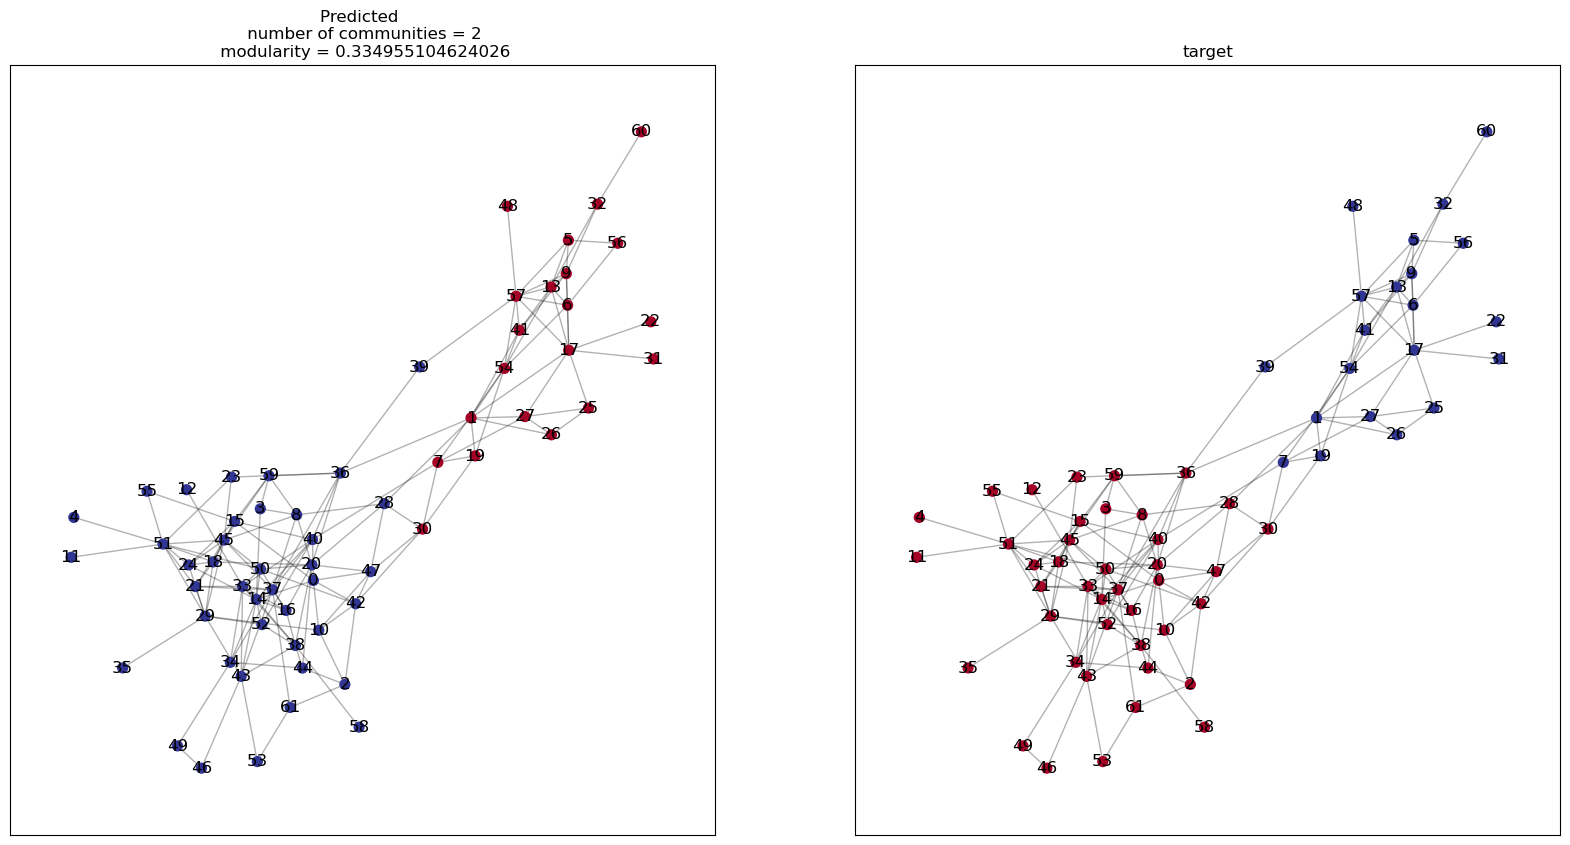

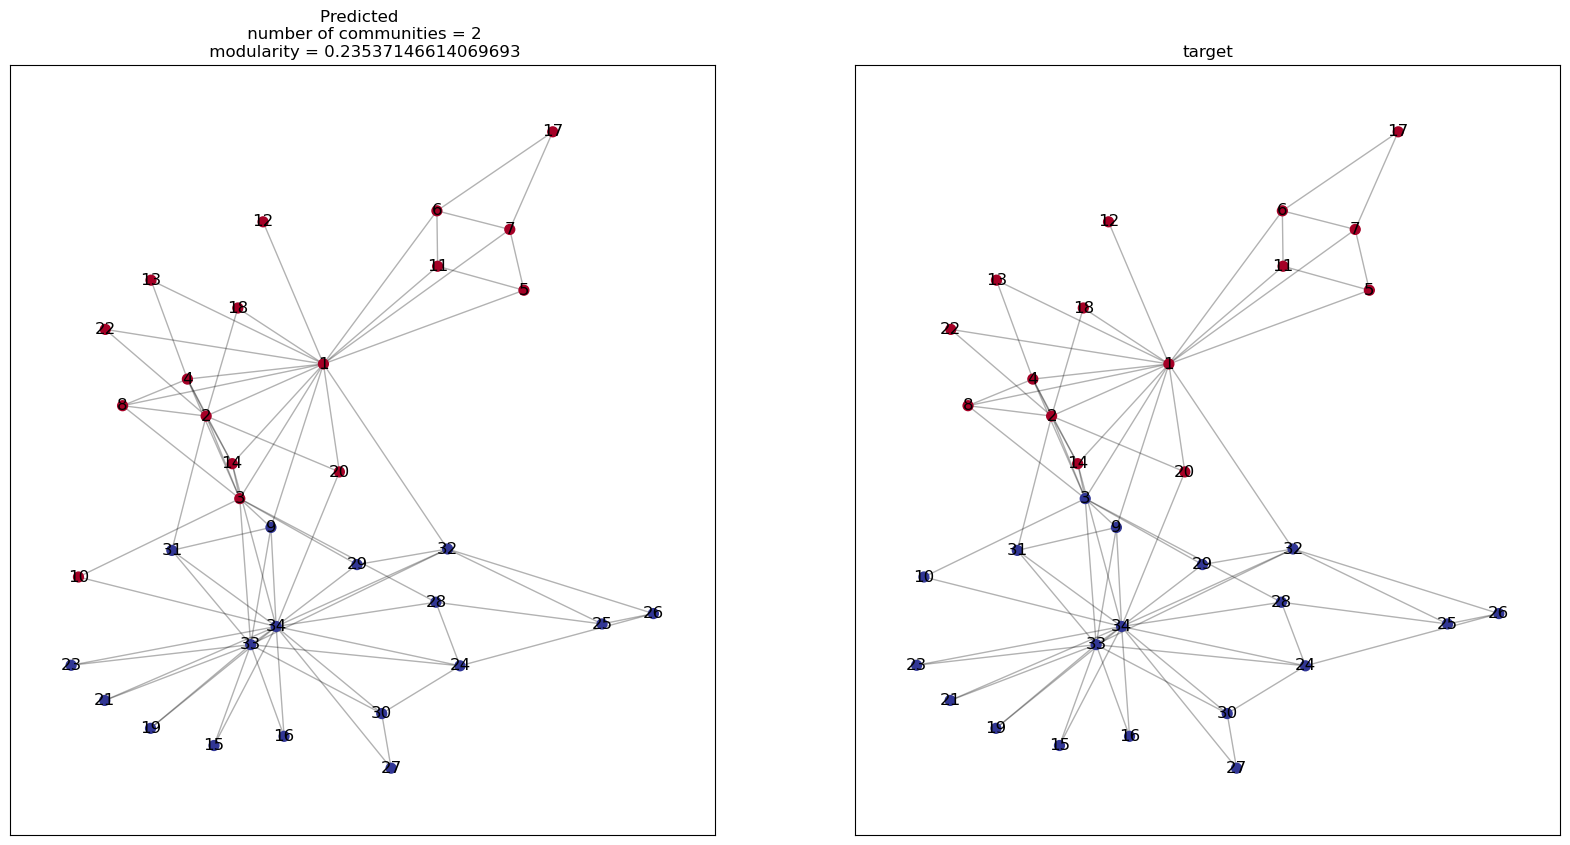

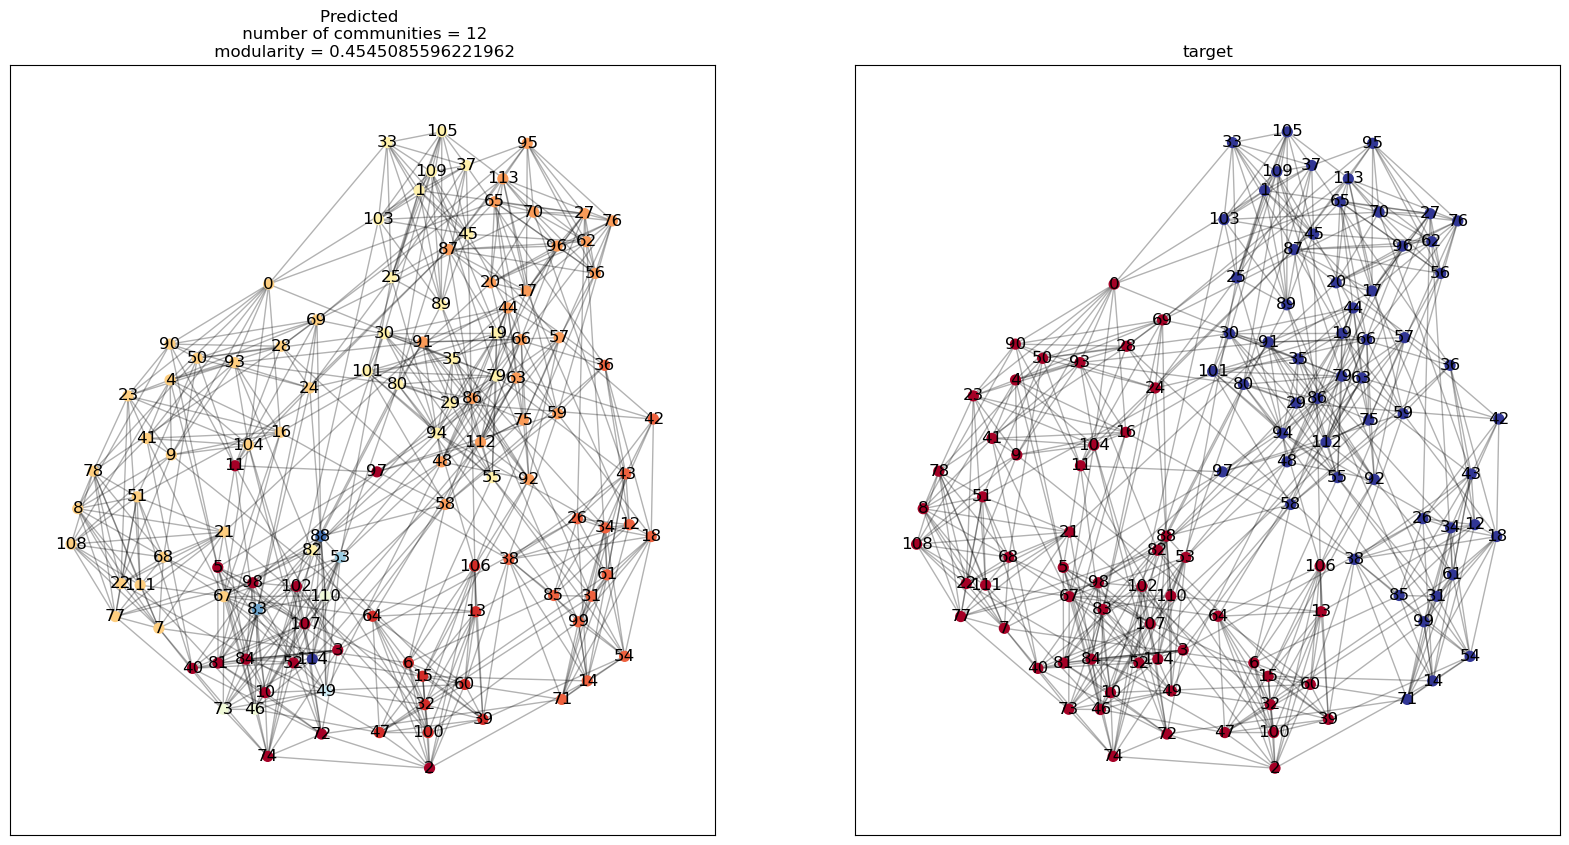

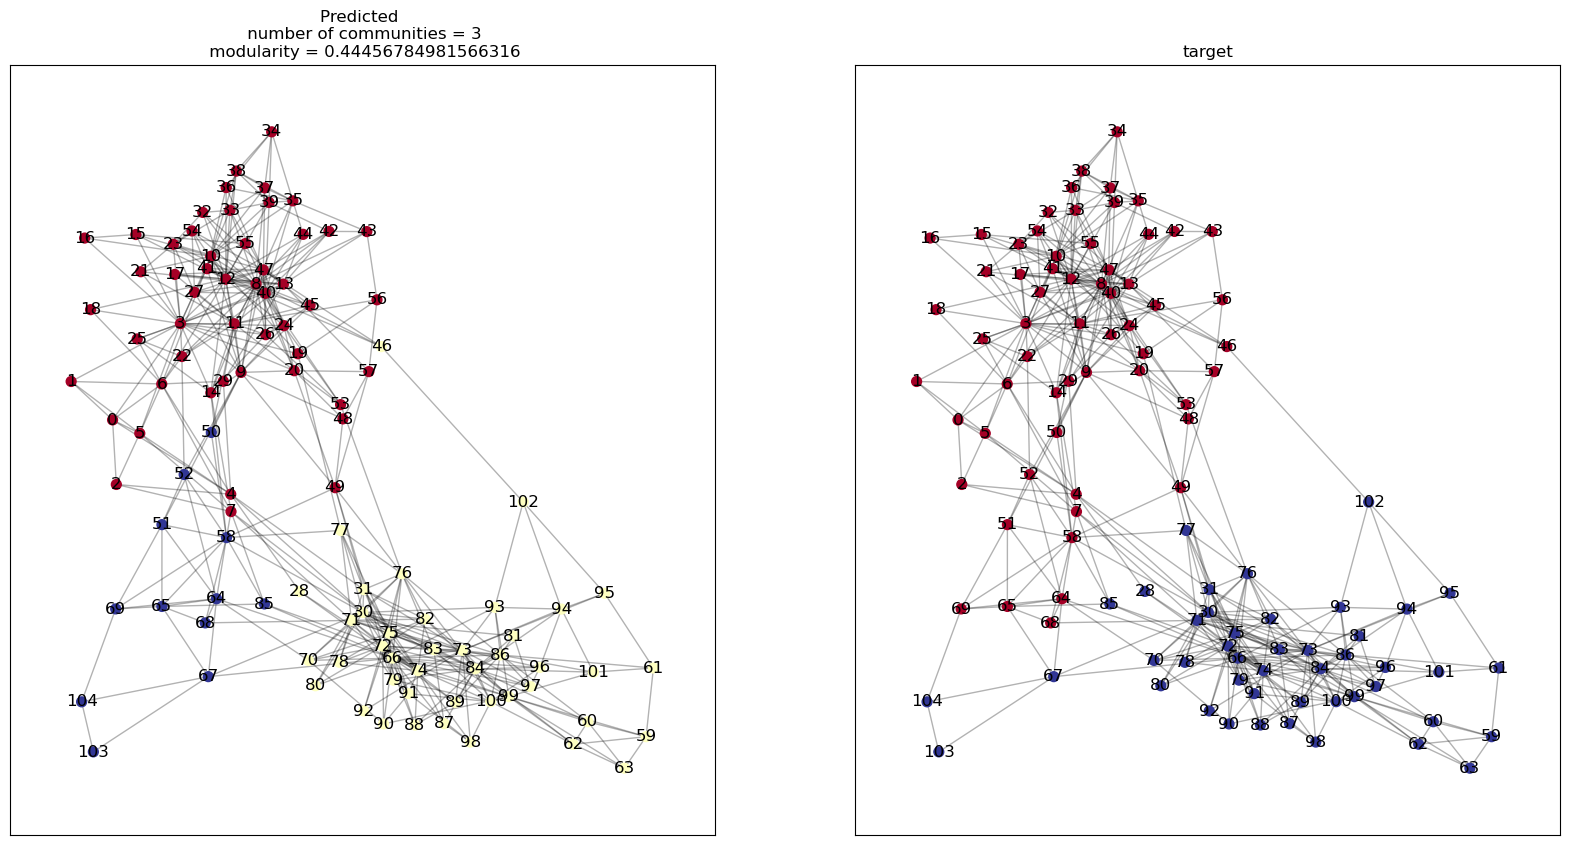

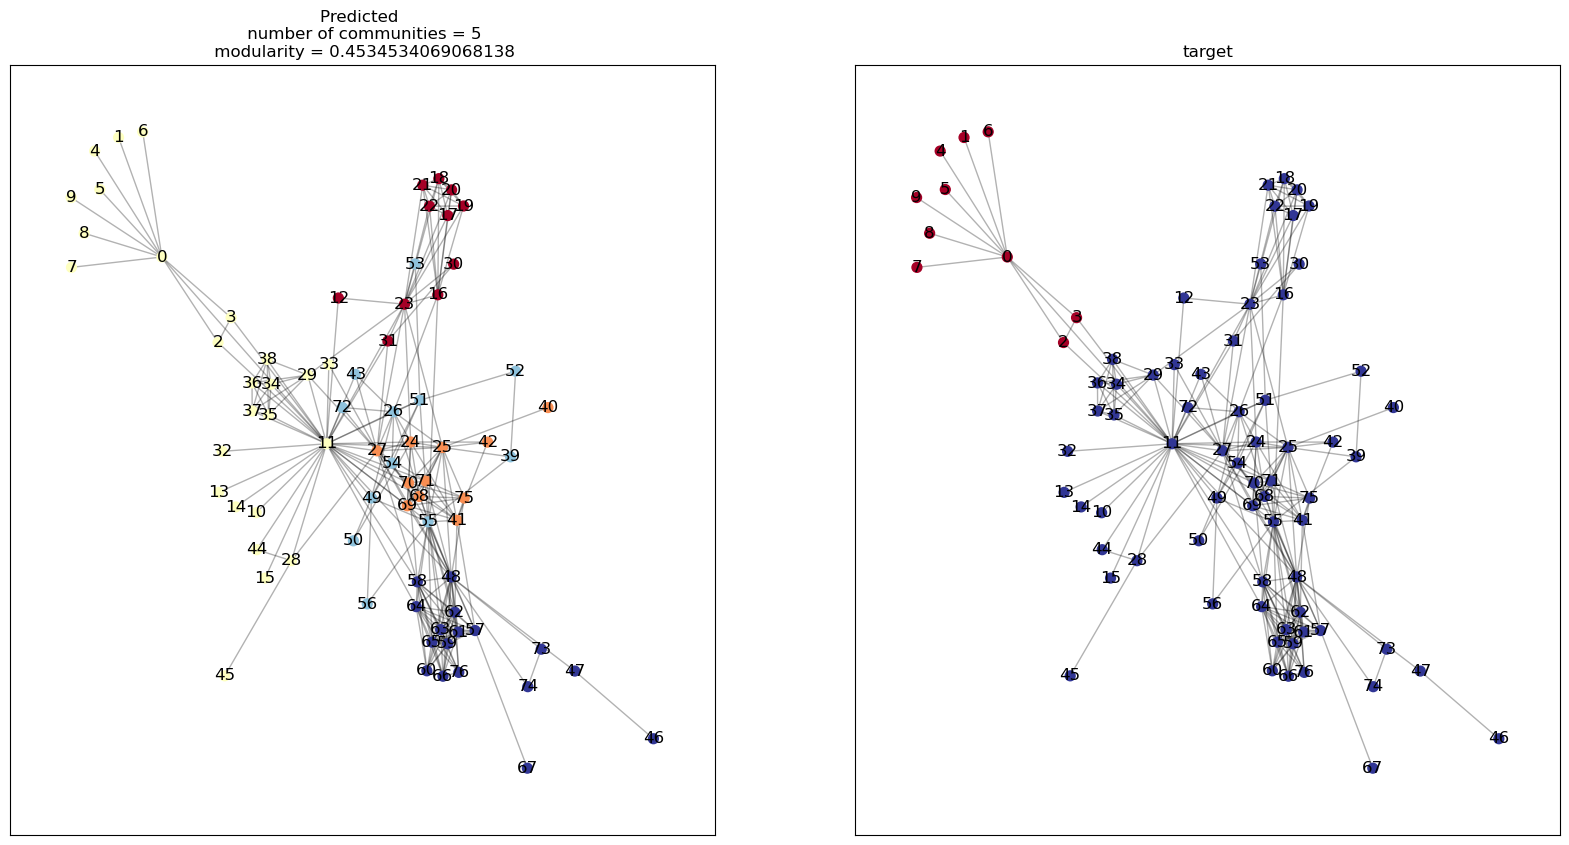

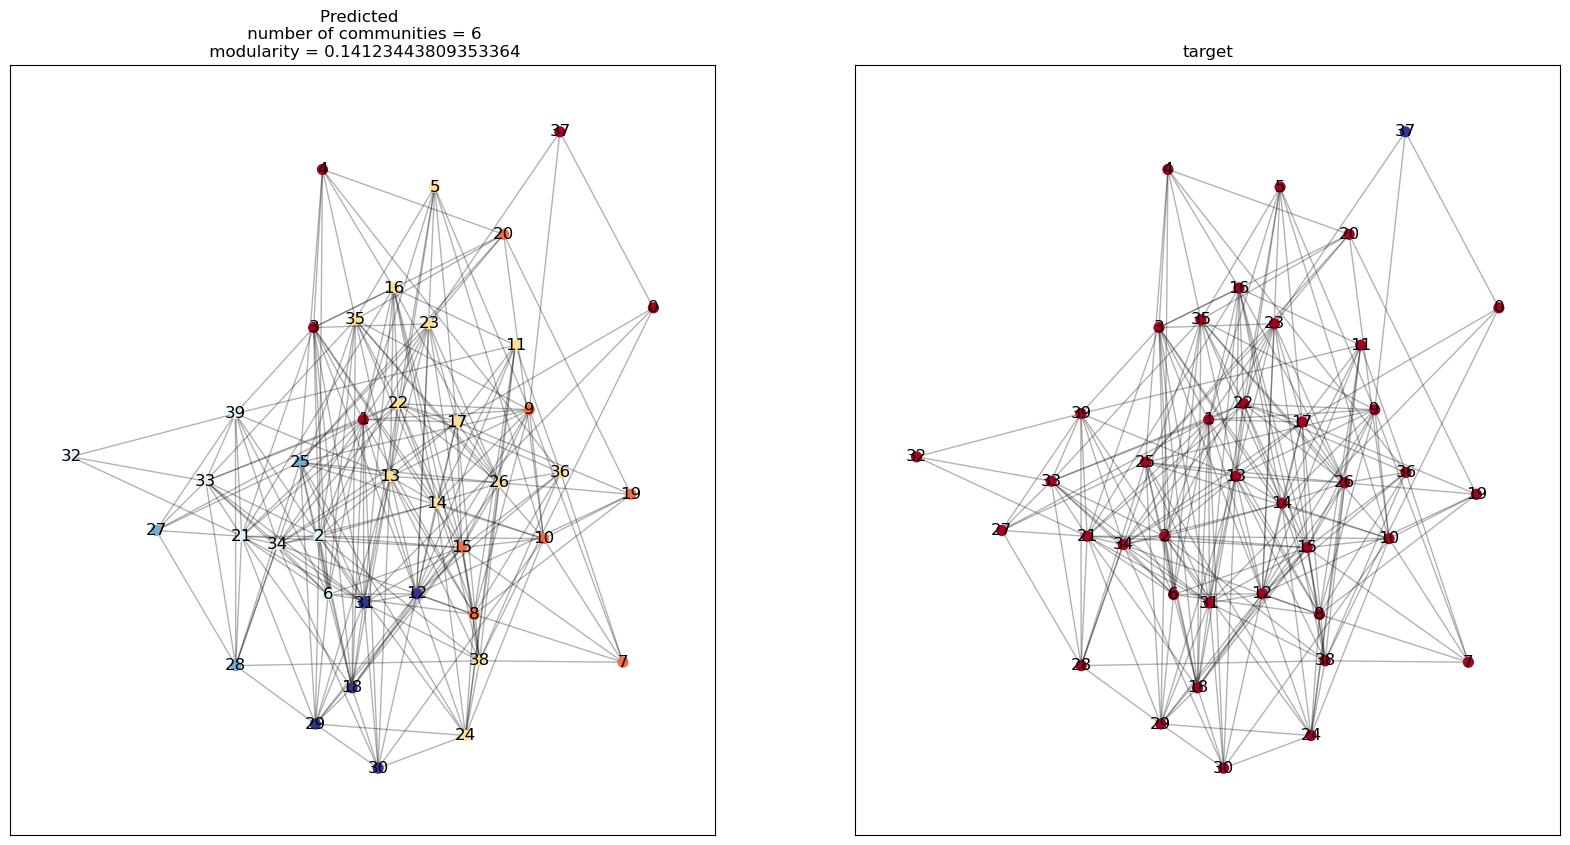

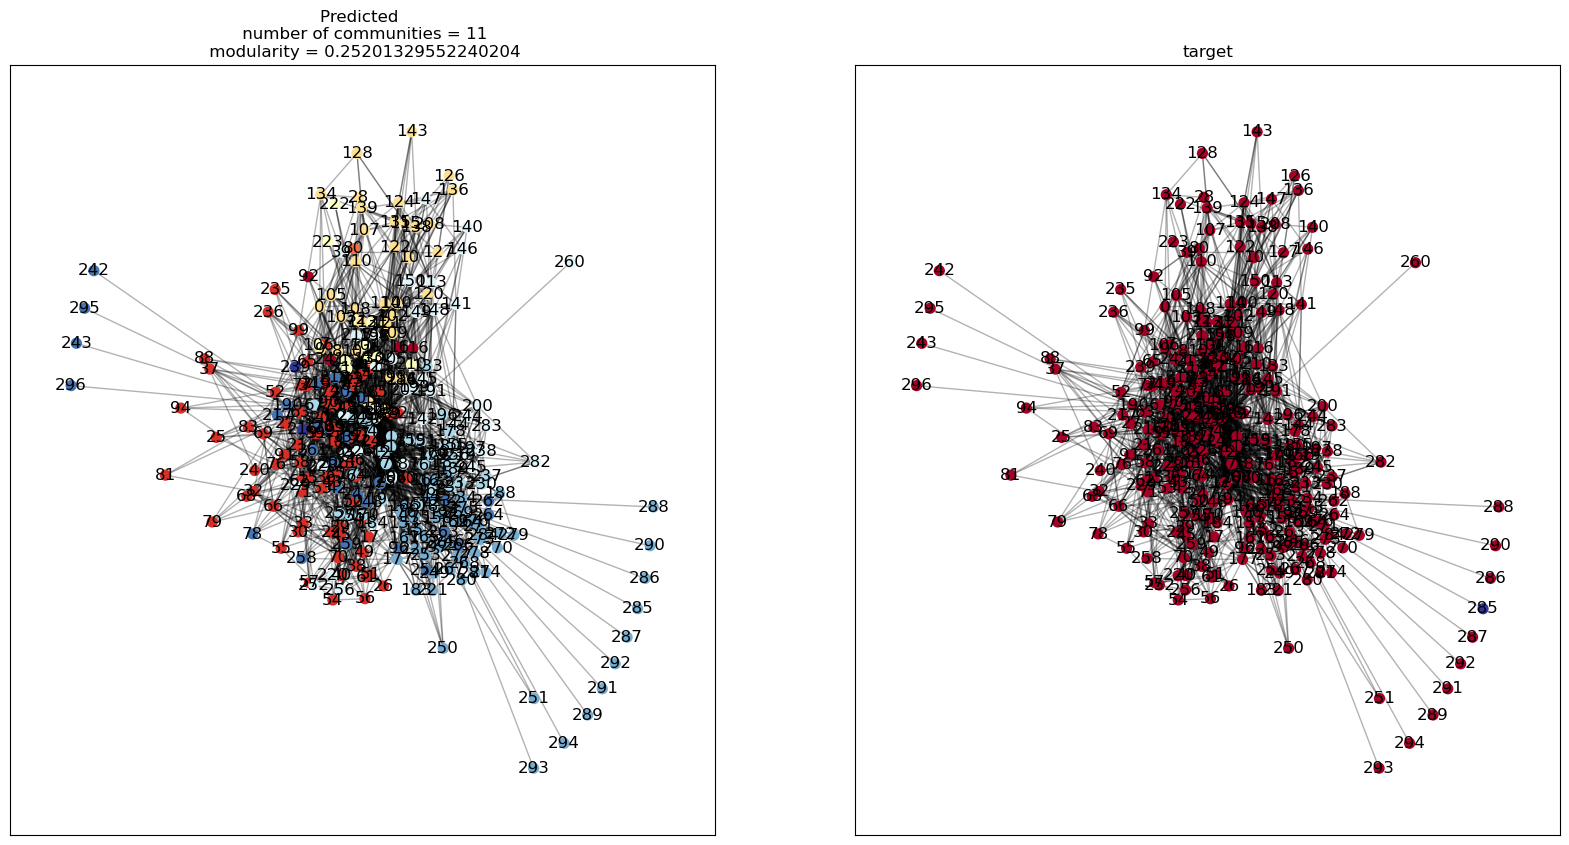

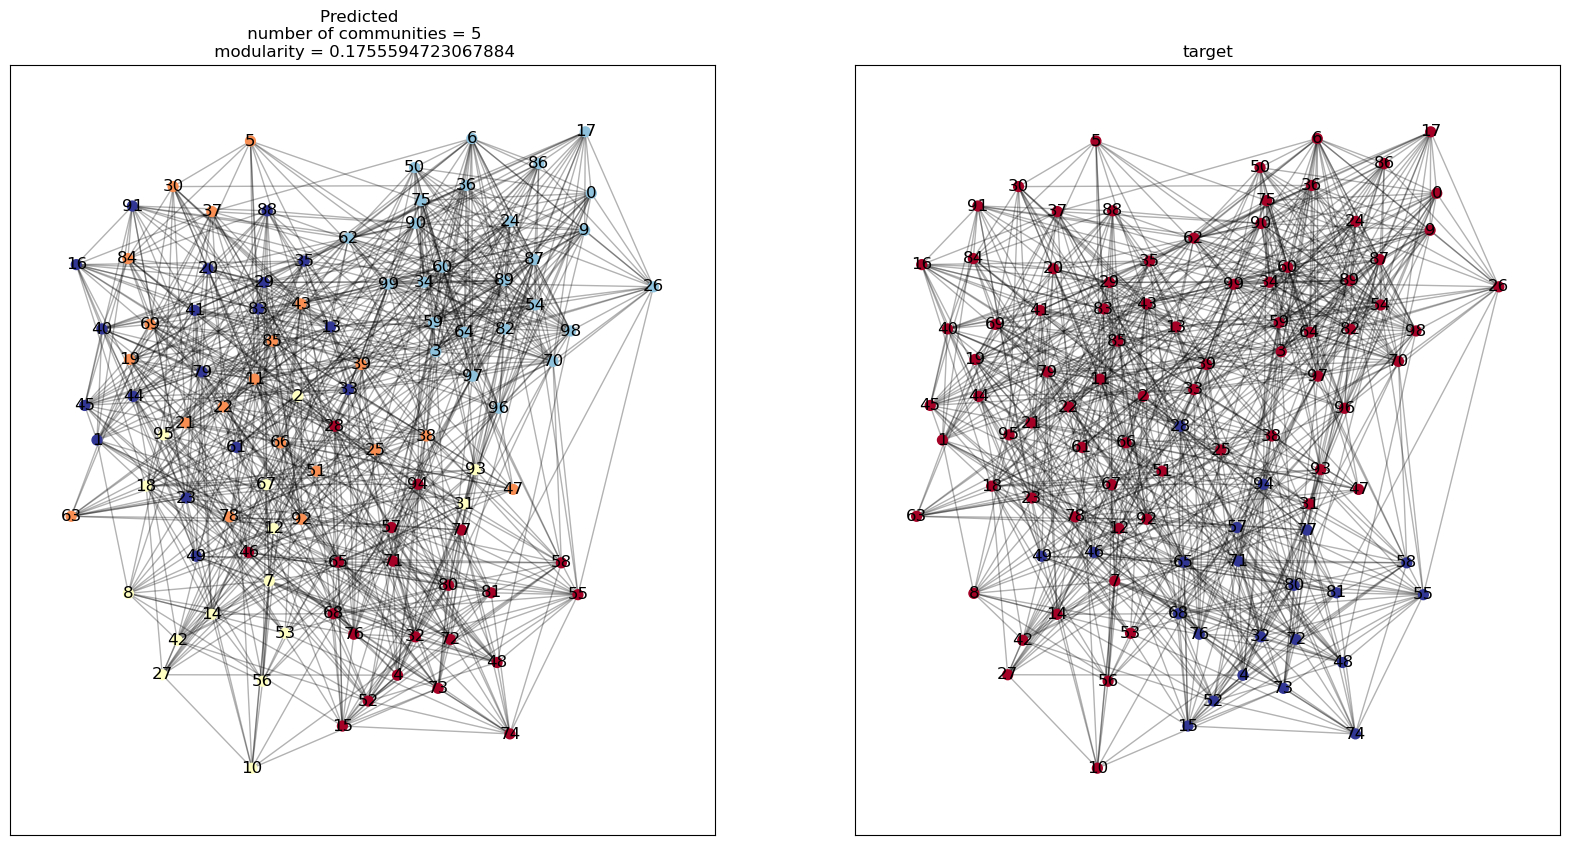

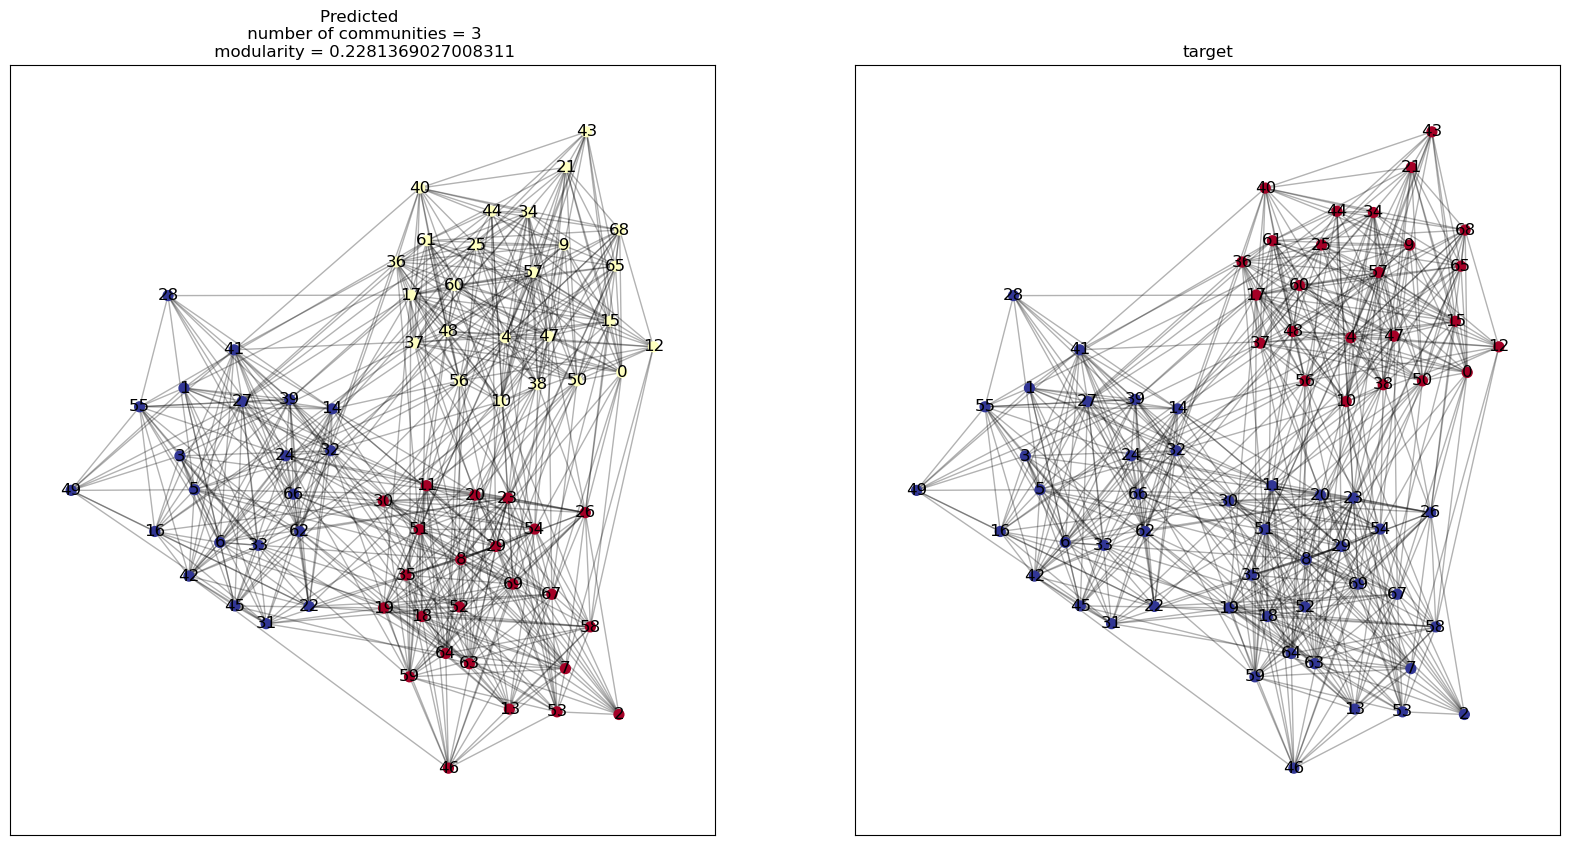

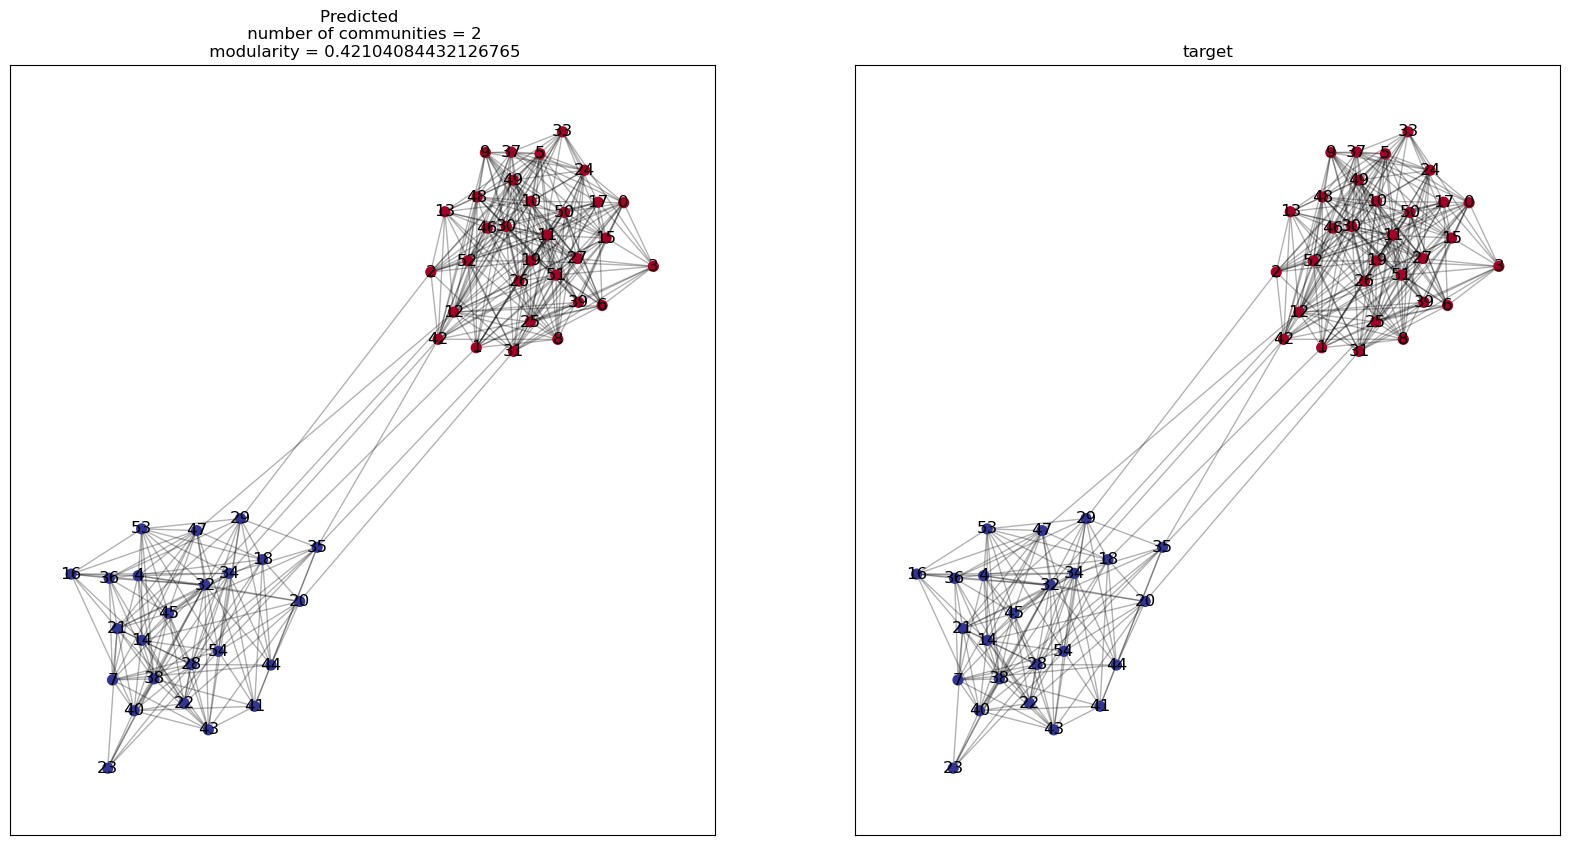

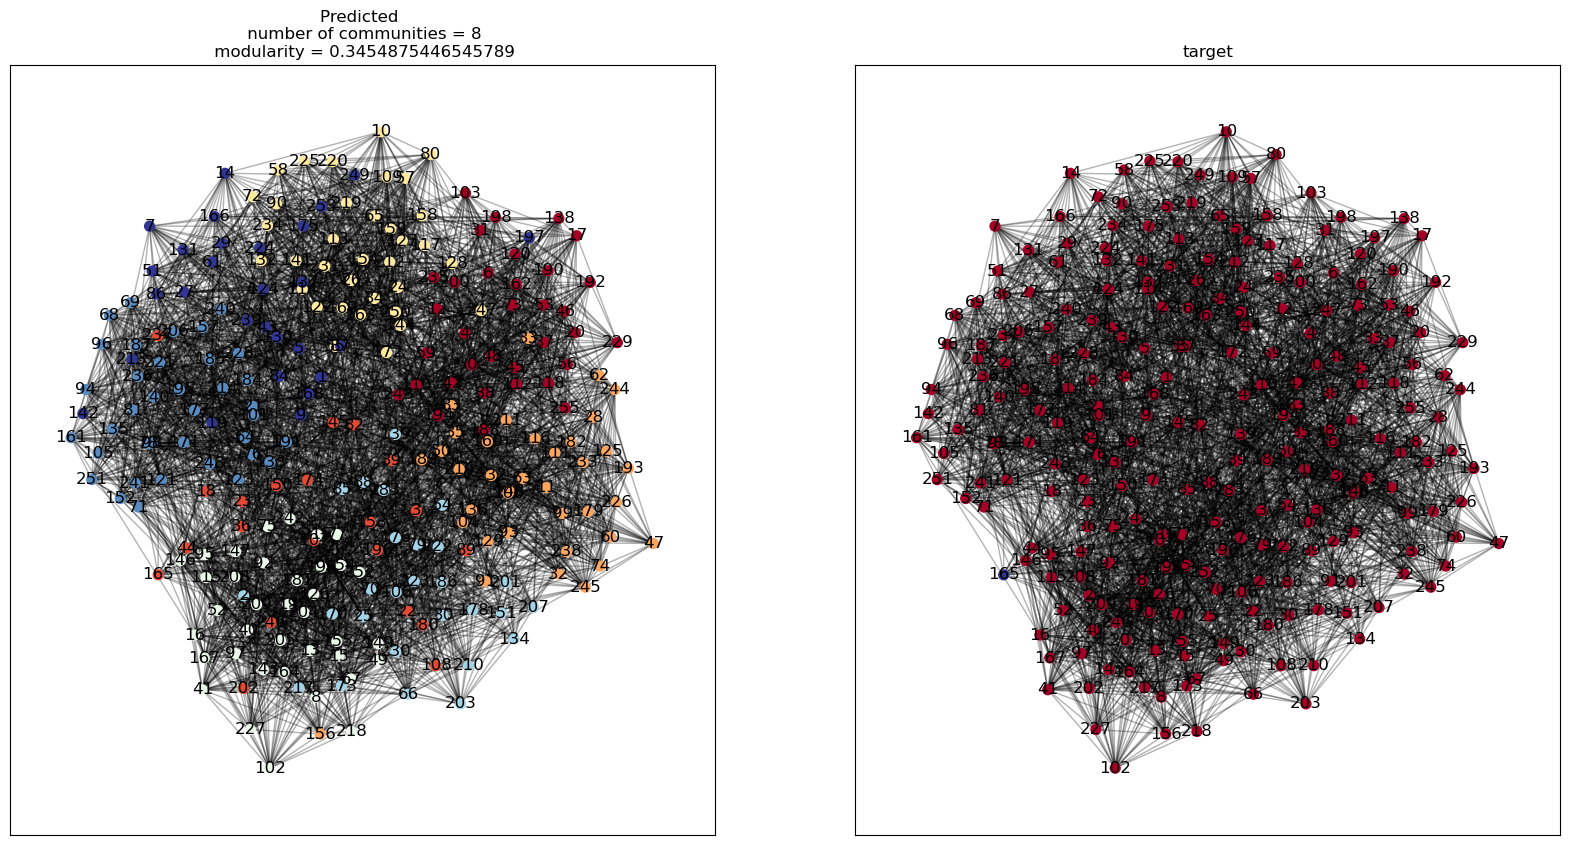

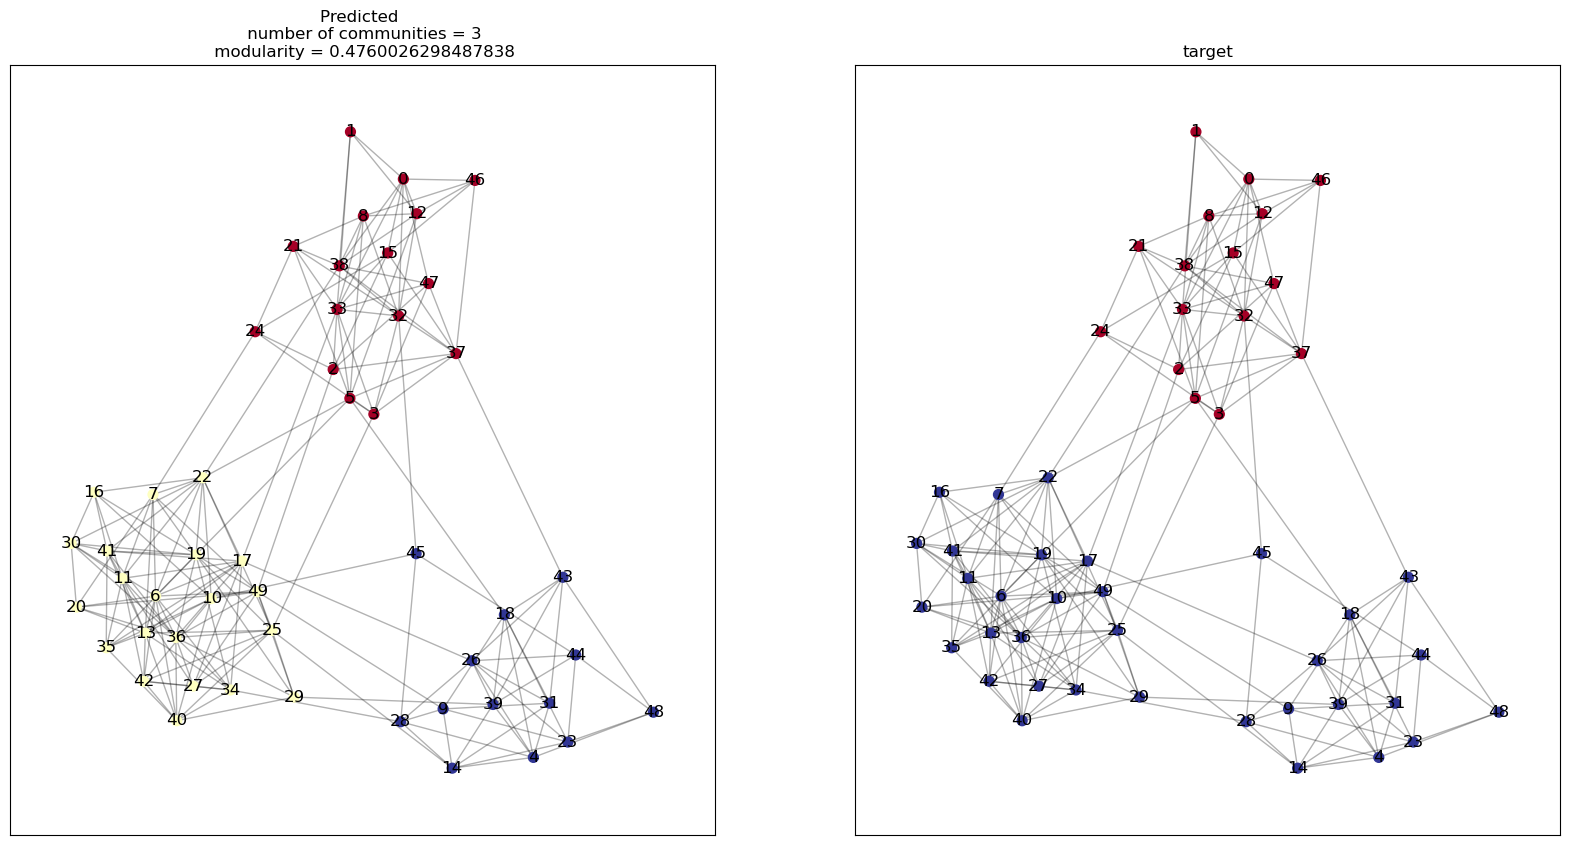

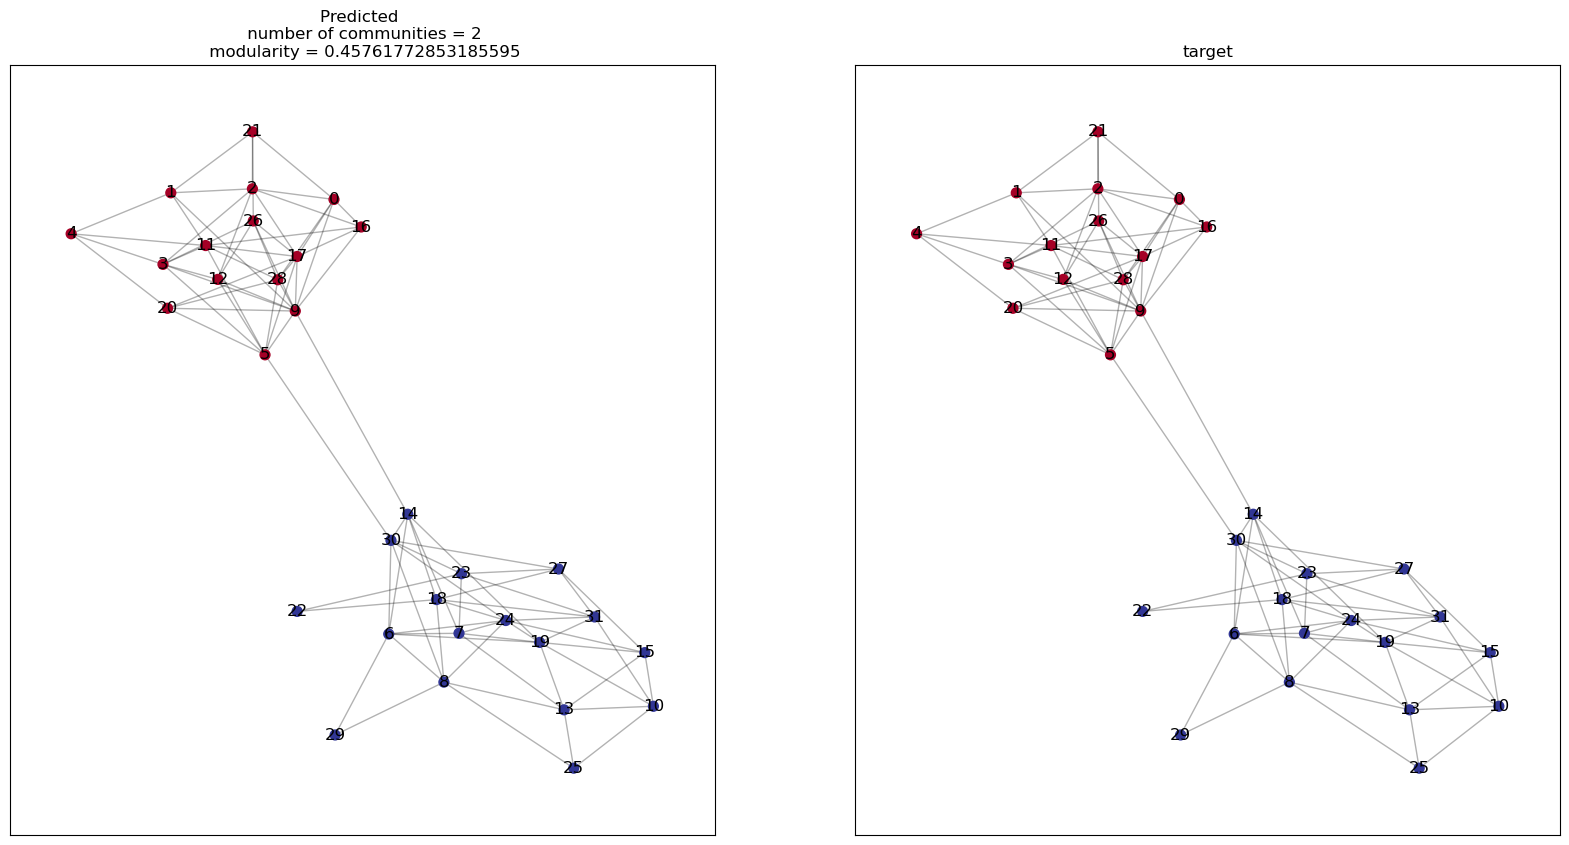

In [ ]:
for network, networkLabels, numberOfCommunities in zip(networks, networksLabels, networkNumberOfCommunities):
    [modularity, predictedCommunities] = greedyCommunitiesDetection(network, numberOfCommunities)
    plotPredictedTargetNetwork(network, modularity, predictedCommunities, networkLabels)

In [ ]:
#classes = greedyCommunitiesDetectionByTool(G) 
#communities = greedyCommunitiesDetection(G, numberOfCommunities)
#print("Accuracy = " + str(accuracy(classes, communities)))
#plotNetwork(G, communities)
#plotNetwork(G, classes)
#plotPredictedTargetNetwork(G, communities, classes)